In [68]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
from gensim import corpora
from gensim.models import TfidfModel, Word2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from warnings import filterwarnings
from nltk.stem import WordNetLemmatizer
from pandas.core.frame import DataFrame
filterwarnings('ignore')


In [69]:
data = pd.read_csv(open("./word.csv", encoding='utf8'), sep=',')
data.head()

,story_title,story_id,reads,votes,chapterNb,first_update,last_update,story_text,preprocess_story_text,language
0,(Hiccup X reader) The One You Needed,262498819-hiccup-x-reader-the-one-you-needed,136K,3.5K,25,"Mar 17, 2021","Jun 12, 2021","YOUR POV Up in the air... High, above the dapp...",air high dappled cloud feel alive place feel a...,__label__en
1,Falling In Love With Tsundere Villainess Afte...,297890055-falling-in-love-with-tsundere-villai...,29.2K,1.6K,60,ished Jan 11,Jan 12,JLL Translations T/N: Hi guys! It’s my first t...,translation hi guy ’ first time ever novel adv...,__label__en
2,The Ultimate Combination With a Little Twist ...,256869090-the-ultimate-combination-with-a-litt...,115K,5.1K,52,"Jan 30, 2021","Nov 03, 2021",Okay so this is my first book and the chapters...,first book chapter short hope guy like woke su...,__label__en
3,Unrequited Love,220872548-unrequited-love,639K,25.2K,44,"Apr 15, 2020","May 16, 2021",It was the most memorable day of my life until...,memorable day life said word devouring lip mov...,__label__en
4,"""Are they my brothers?"" ✔️",272016075-are-they-my-brothers-%E2%9C%94%EF%B8%8F,258K,5.8K,19,"Jun 01, 2021","Jul 14, 2021",Hello! Bonjour! Hola! Ciao! Thank you so much ...,hello thank much choosing read book first book...,__label__en


word = Cyberpunk text word2 = romantic. Other content does not need to be changed

In [70]:
stopwords = nltk.corpus.stopwords.words('english')
Ewords = set(nltk.corpus.words.words())
Englishlemmatizer = WordNetLemmatizer()

def Preprocess_list_of_English_Sentence(listofSentence):
    preprocess_list = []
    for sentence in listofSentence :
        
        sentence_w_punct = "".join([i.lower() for i in sentence if i not in string.punctuation])
        
        sentence_w_num = ''.join(i for i in sentence_w_punct if not i.isdigit())
        
        tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_num)
        
        words_w_stopwords = [i for i in tokenize_sentence if i not in stopwords]
        
        words_lemmatize = (Englishlemmatizer.lemmatize(w) for w in words_w_stopwords)
        
        sentence_clean = ' '.join(w for w in words_lemmatize if w.lower() in Ewords or not w.isalpha())
        # rebuild the text
        preprocess_list.append(sentence_clean)

    return preprocess_list

In [71]:
data1 = data['preprocess_story_text']

In [72]:
cut_word_list = np.array([str(cont).split() for cont in data1.tolist()])
dictionary = corpora.Dictionary(cut_word_list)
corpus = [dictionary.doc2bow(text) for text in cut_word_list]

In [73]:
def word2vec_model():
    model = Word2Vec(cut_word_list, vector_size=200, window=5, min_count=1, seed=1, workers=4)
    model.save('word2vec.model')
word2vec_model()
model = Word2Vec.load('word2vec.model')
model.train(cut_word_list, total_examples=model.corpus_count, epochs=10)
wv = model.wv

In [74]:
def get_word2vec_vec(content=None):
    text_vec = np.zeros((content.shape[0], 200))
    for ind, text in enumerate(content):
        wlen = len(text)
        vec = np.zeros((1, 200))
        for w in text:
            try:
                vec += wv[w]
            except:
                pass
        text_vec[ind] = vec/wlen
    word2vec = pd.DataFrame(data=text_vec)
    word2vec.to_csv('word2vec.csv', index=False)
    return text_vec
    
word2vec = get_word2vec_vec(cut_word_list)

In [75]:
word_id = dictionary.token2id
tfidf_model = TfidfModel(corpus, normalize=False)
corpus_tfidf = [tfidf_model[doc] for doc in corpus]
corpus_id_tfidf = list(map(dict, corpus_tfidf))

def get_tfidf_vec(content=None):
    text_vec = np.zeros((content.shape[0], 200))
    for ind, text in enumerate(content):
        wlen = len(text)
        vec = np.zeros((1, 200))
        for w in text:
            try:
                if word_id.get(w, False):
                    vec += (wv[w] * corpus_id_tfidf[ind][word_id[w]])
                else:
                    vec += wv[w]
            except:
                pass
        text_vec[ind] = vec/wlen
    tfidf = pd.DataFrame(data=text_vec)
    tfidf.to_csv('tfidf_vec.csv', index=False)
    return text_vec
    
tfidf = get_tfidf_vec(cut_word_list)

In [76]:
def silhouette_score_show(data_vec=None, name=None):
    k = range(2, 10)
    score_list = []
    for i in k:
        model = KMeans(n_clusters=i).fit(data_vec)
        y_pre = model.labels_
        score = round(silhouette_score(data_vec, y_pre), 2)
        score_list.append(score)
    plt.figure(figsize=(12, 8))
    plt.plot(list(k), score_list)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.savefig(f'{name}test.jpg')
    plt.show()

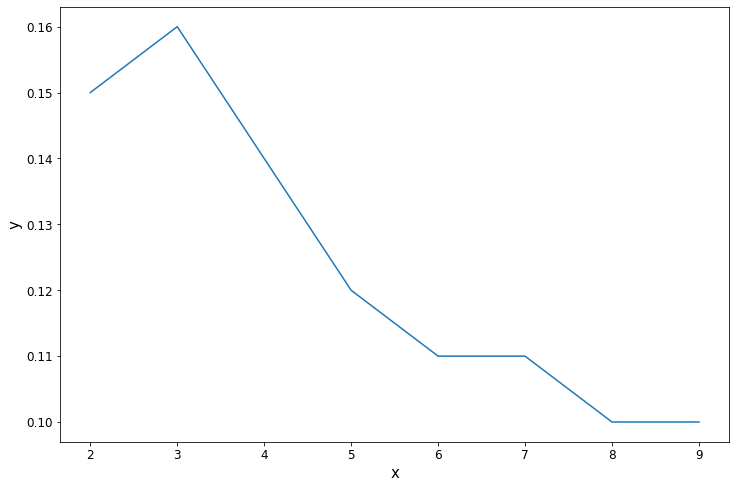

In [77]:
silhouette_score_show(word2vec, 'word2vec')

Depending on the word, different graphics can be obtained. This is the word2vec_model of Cyberpunk

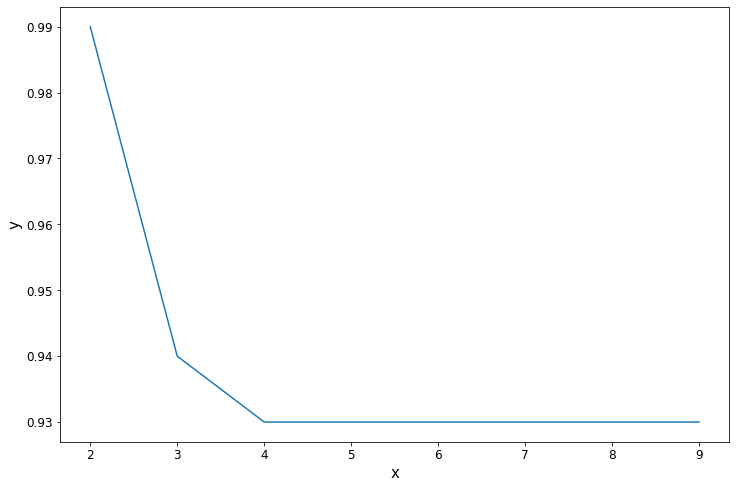

In [78]:
silhouette_score_show(tfidf, 'tfidf')

Depending on the word, different graphics can be obtained. This is the TF-IDF_model of Cyberpunk

In [79]:
kmeans = KMeans(n_clusters=8).fit(tfidf)
y_pre = kmeans.labels_
labels = pd.DataFrame(y_pre)
labels.value_counts()

0    1163
4       8
5       7
1       1
2       1
3       1
6       1
7       1
dtype: int64

The clustering results are shown as above:

In [80]:
data = pd.DataFrame(tfidf)
data_label = pd.concat([data, labels], axis=1) 
data_label.columns = [f'vec{i}' for i in range(1, tfidf.shape[1]+1)]  + ['label']
data_label.head()

,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,vec9,vec10,...,vec192,vec193,vec194,vec195,vec196,vec197,vec198,vec199,vec200,label
0,5.992959,-6.989514,7.982764,0.620407,-7.978211,12.531544,-6.381421,-10.066463,-2.763374,-4.825517,...,-5.085209,-1.508271,-5.156376,-2.839882,-3.838032,6.102067,-0.774607,11.703692,6.369738,0
1,66.760386,263.465858,-71.691236,-71.863491,54.342320,-40.829551,-170.018064,325.561813,-102.234190,-185.539820,...,70.715355,83.697676,-140.840855,265.980387,-75.525245,73.750455,-60.334128,201.544028,61.609400,0
2,-0.194102,0.610211,3.282639,-2.226799,-1.533569,0.578506,1.031776,-1.414757,-0.148760,-0.459124,...,-1.472203,-0.190655,0.265979,2.251711,-0.175129,1.697578,0.376275,-1.236571,1.519478,0
3,1.963755,1.279029,-1.840163,0.453215,0.836258,-0.763896,0.873277,-4.569125,-1.476918,-0.109428,...,-2.019218,-6.683120,-4.012132,0.578731,-3.346577,2.238034,4.296256,-2.026837,1.203245,0
4,-0.668520,0.536768,3.005200,0.574885,-0.883002,1.359358,1.252418,-1.163413,1.058176,-2.906990,...,-0.925799,-0.073790,1.762368,-2.568941,-2.479453,0.848524,-0.098759,0.621601,-1.737888,0


TSNE display results

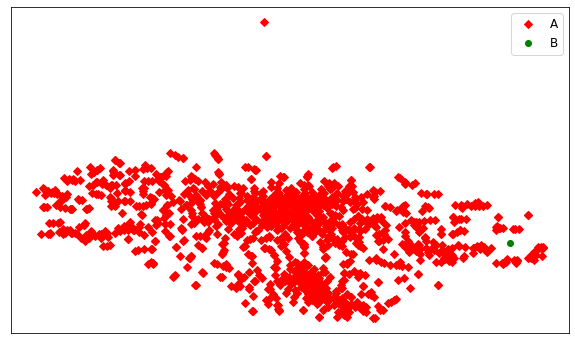

In [81]:
tsne = TSNE()
tsne.fit_transform(data_label) 
tsne = pd.DataFrame(tsne.embedding_,index=data_label.index)
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
d = tsne[data_label['label'] == 0]
plt.plot(d[0],d[1],'rD')
d = tsne[data_label['label'] == 1]
plt.plot(d[0],d[1],'go')
plt.xticks([])
plt.yticks([])
plt.legend(['A', 'B'], fontsize=12)
plt.savefig('TEST.jpg')
plt.show()

Total introduction

In the whole unsupervised process, we found that it is difficult to perform unsupervised clustering of a certain type of text according to the code, the main reason is that the keyword vectors of the unsupervised clustering in similar texts are similar. Here we cluster the texts of Romantic and Cyberpunk respectively. We can observe that the effect is not good, or the effect is not obvious according to the TSNE graph. The word vector method we use includes the most basic TFIDF and a higher layer of Word2Vec.

Among them, TFIDF is suitable for simple text classification, such as putting different types of text together for word vector labeling. Word2Vec will focus on semantic analysis, making the association between similar words more closely.

Finally, we calculate the vector value of each article from the word vector, and perform clustering detection on the content of the entire CSV/JSON document based on K-Mean to obtain the result.